Modify the classifcation layers to predict the new objects with existing model.

![transfer_learning_principles](./transfer_learning/transfer_learning_principles.png)

## Example

In this example, we will use the pre-trained RestNet 18CNN. It was trained on more than a million images from the imagenet database.
Have 18 layers and can classify images into 1000 object category.

### We will detect bees and ants 

<span style='color:cyan'>We will also learn 
* <span style='color:cyan'>image folder
* <span style='color:cyan'>scheduler to change the learning rate
* <span style='color:cyan'>transfer learning </span>

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets,models, transforms
import matplotlib.pyplot as plt
import time
import pathlib
import copy

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
mean = std = np.array([0.5,0.5,0.5])

## Data Transform

In [18]:
data_transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # check cell [11-13] from 12_convolutional_NN
        transforms.Normalize(mean=mean,std=std)
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std)
    ])
}

## Data Loading

In [19]:
print([pathlib.Path.cwd().joinpath('dataset','hymenoptera_data',x)for x in ['train','val']])


[WindowsPath('c:/Users/msi/Desktop/pytorch/dataset/hymenoptera_data/train'), WindowsPath('c:/Users/msi/Desktop/pytorch/dataset/hymenoptera_data/val')]


In [20]:
image_datasets = {x:datasets.ImageFolder(root = pathlib.Path.cwd().joinpath('dataset','hymenoptera_data',x),transform=data_transform[x])for x in ['train','val']}

In [21]:
for i in image_datasets.values():
    print(i.class_to_idx)
    print(i.classes)

{'ants': 0, 'bees': 1}
['ants', 'bees']
{'ants': 0, 'bees': 1}
['ants', 'bees']


In [22]:
dataloaders = {
    x:torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size = 4,
        shuffle = True) for x in ['train','val']
}

In [23]:
# Yes!image_dataset can call len function.
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
print(f'Dataset Size is {dataset_sizes}')
print(f'Class names are {class_names}')

Dataset Size is {'train': 244, 'val': 153}
Class names are ['ants', 'bees']


In [24]:
def imshow(inp,title):
    """Imshow for Tensor"""
    # First input is Tensor. So, change the tensor to numpy
    # then we have to change the shape of (3,224,224) to (224,224,3)
    # check cell [23 - 26]
    # shape[0]==3 has to be in 3rd index. That's why (0,1,2) to (1,2,0)
    inp = inp.numpy().transpose((1,2,0))
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [25]:
# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))
print('We transformed input images to the range between -1 and 1 with transform.Normalize in cell [11]. And randomcrop all images to uniform size of 224x224.')
print(f'As you can see, minimum and maximum of Tensor is between {inputs.data.min()} and {inputs.data.max()}. Size is {inputs.data.shape}')

We transformed input images to the range between -1 and 1 with transform.Normalize in cell [11]. And randomcrop all images to uniform size of 224x224.
As you can see, minimum and maximum of Tensor is between -1.0 and 1.0. Size is torch.Size([4, 3, 224, 224])


## <span style='color:cyan'>MAKING GRID FROM BATCH</span>
## squish a batch of 4 photos into one row. 
## That's why the width of the shape is 224x4 = 896
## click [here.](https://pytorch.org/vision/stable/utils.html#torchvision.utils.make_grid)


In [26]:
grid_img = torchvision.utils.make_grid(inputs)
print(grid_img.shape)

torch.Size([3, 228, 906])


## <span style='color:cyan'>Grid is just for showing the image. We don't use it in neural network.</span>

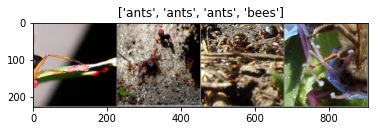

In [27]:
imshow(grid_img,title=[class_names[x] for x in labels])

# **Image Show For First Image of First Batch**

In [28]:
# this is tensor
single_img = inputs.data[0] 
# this is numpy array
single_img = single_img.numpy()
print(f'the shape before is {single_img.shape}')
# values are in range(-1,1)
print(f'Max Min value is {single_img.max()},{single_img.min()}')
# (3,224,224) to (224,224,3)
single_img = single_img.transpose((1,2,0))
print(f'the shape after is {single_img.shape}')

the shape before is (3, 224, 224)
Max Min value is 1.0,-1.0
the shape after is (224, 224, 3)


## after putting the rgb channels column to the back, we have to undo the mean and standard deviation of the image.

max and min value of this image is 1.0, 0.0


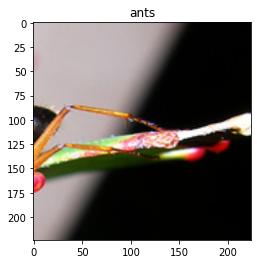

In [29]:
single_img = std*single_img + mean
# np.clip does revaule any value outside of the range(0,1) will be regarded as 0 and 1.
single_img = np.clip(single_img,0,1)
print(f'max and min value of this image is {single_img.max()}, {single_img.min()}') 
plt.imshow(single_img)
plt.title(class_names[labels[0]])
plt.show()

### state_dict() is object that maps each layer to its parameter tensor. It is a complete entity for saving or loading models from pytorch.

### set_grad_enabled() is used as Context-manager that sets gradient calculation to on or off.

### torch.max(input,dim) Returns a namedtuple (values, indices) where values is the maximum value of each row of the input tensor in the given dimension dim. For example, if dim = 0, it will find max value of each column. if dim = 1, it will find max value of each row.

## outputs = model(input)
### outputs shape will be [4,2]. 4 means 4 photos in each batch. For each photo, there will be probability for each of the labels. There is 2 classes to to predictied {ants,bees}. That's why there is two.
### we want to find the max value (which means what is the output predction {ants or bees???} in each row.) That's why torch.max has dim = 1.

### example output
### tensor([[-0.3104, -0.4040],     
###        [-0.2068, -0.4613],      
###        [-0.1648, -0.4859],      
###        [ 0.7571, -0.2535]])    

### as loss.item() is based on batch of 4 photos, running loss is 4 x loss.item()

### running_loss now have total loss of all photos. So, for 1 epoch for an image, we divied the total loss with total number of photos.

In [61]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # below three will run wherether it is train or val.
                    # that's why there is phase == 'train' in 4th line.
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


# <span style='color:cyan'>There are two techiques in modifying model.</span>
* ## Fine Tuning 
* ## Freeze all layers and only train last layer

# <span style='color:cyan'>Fine Tuning</span>

Fine-tuning is a way of applying or utilizing transfer learning. Specifically, fine-tuning is a process that takes a model that has already been trained for one given task and then tunes or tweaks the model to make it perform a second similar task.

### <span style='color:cyan'> this will retrain the model<span>

In [62]:
# loading pretrained model
model = models.resnet18(pretrained=True)
print(f'initially there are {model.fc.out_features} outputs from resnet fully connected layer')

initially there are 1000 outputs from resnet fully connected layer


In [63]:
# in order to exchange the fc layer, we need to know the numbers of input feature which will be used in constructing new fc layer.
# fc means fully connected layer.
num_features = model.fc.in_features
print(f'number of input features in exsiting last fully connected layer {num_features}')

number of input features in exsiting last fully connected layer 512


In [64]:
# create new layer with same number of input features but change no of out features which would be 2. [ants, bees] to our liking.
model.fc = nn.Linear(in_features=num_features,out_features=len(class_names))
model.to(device)

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.001)

## Scheduler will update the learning rate

There is so [many lr_schedular](https://pytorch.org/docs/stable/optim.html) and those can be called by chaining.The result is that each scheduler is applied one after the other on the learning rate obtained by the one preceding it.

<span style='color:cyan'>if we call the schedular.step() before the optimizer.step(), this will skip the 1st value of learing rate schedule.</span>

In [65]:
# every 7 epoch, our learning rate would be multiplied by gamma.
step_scheduler = lr_scheduler.StepLR(optimizer=optimizer,step_size=7,gamma=0.1)

In [66]:
model = train_model(model=model,criterion=criterion,optimizer=optimizer,scheduler=step_scheduler,num_epochs=20)

Epoch 0/1
----------
train Loss: 0.6876 Acc: 0.5861
val Loss: 0.5108 Acc: 0.7974

Epoch 1/1
----------
train Loss: 0.5308 Acc: 0.7787
val Loss: 0.3598 Acc: 0.8954

Training complete in 0m 18s
Best val Acc: 0.895425


# <span style='color:cyan'>Freezing and Training Last Layer</span>

## <span style='color:cyan'>This would be more faster</span>

### First freeze the model parameters

In [ ]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    # This will freeze all layer in the beginning
    param.requires_grad = False

In [ ]:
num_features = model.fc.in_features
model.fc = nn.Linear(in_features=num_features,out_features=2)
model.to(device)

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.001)

step_scheduler = lr_scheduler.StepLR(optimizer=optimizer,step_size=7,gamma=0.1)

model = train_model(model=model,criterion=criterion,optimizer=optimizer,scheduler=step_scheduler,num_epochs=20)